In [2]:
from Data import Depthset, Agument, toTensor
from models import Model

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

import mat73
import kornia
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
file_path = "./data/nyu_depth_v2_labeled.mat"
data_dict = mat73.loadmat(file_path)

dataset = Depthset(
    data_dict=data_dict,
    transform=transforms.Compose([Agument(probability=0.5),toTensor()])
    )
print("dataset loaded")

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


dataset loaded


In [3]:
model = Model().cuda()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

epochs = 50
lr = 0.0001
batchsize = 8

train_loader = DataLoader(
    dataset=dataset,
    batch_size=batchsize,
    shuffle=True
    )

optimizer = torch.optim.Adam(model.parameters(),lr)
criterion = nn.L1Loss()
ssim = kornia.losses.SSIMLoss(window_size = 11, max_val = 1000.0 / 10.0, reduction='none')

losses = []
loss_epoch = []

for epoch in range(epochs):
    cum_loss = 0
    counter = 0

    
    model.train()
    start = time.time()
    for i,batch in enumerate(train_loader):
        optimizer.zero_grad()

        image = batch['image'].cuda()
        depth = batch['depth'].cuda()

        depth = 1000.0 / depth

        out = model(image)

        loss = criterion(out, depth)
        l_ssim = torch.clamp((1 - ssim(out, depth)) * 0.5, 0, 1)
        loss = (1.0 * l_ssim.mean().item()) + (0.1 * loss)

        losses.append(loss.item())
        cum_loss += loss.item()
        counter += 1

        loss.backward()
        optimizer.step()

    loss_epoch.append(cum_loss/counter)

    with open("./trained_models/loss_log",'wb') as fp:
        pickle.dump(losses,fp)

    with open("./trained_models/epoch_loss_log",'wb') as fp:
        pickle.dump(loss_epoch,fp)

    path = f"./trained_models/{epoch}.pth"
    torch.save(model.state_dict(),path)

    end = time.time()

    print(f"[{epoch}/{epochs}] loss: {cum_loss} time: {end - start}")
    


[0/50] loss: 545.1849279403687 time: 173.84489917755127
[1/50] loss: 352.62832152843475 time: 172.79069185256958
[2/50] loss: 308.8652274608612 time: 195.86176943778992
[3/50] loss: 298.69083750247955 time: 205.3348367214203
[4/50] loss: 290.95823788642883 time: 228.58640360832214
[5/50] loss: 294.1490936279297 time: 214.72597098350525
[6/50] loss: 272.1088819503784 time: 211.47890615463257
[7/50] loss: 257.3126937150955 time: 218.44366455078125
[8/50] loss: 280.8701751232147 time: 216.91672110557556
[9/50] loss: 264.2503002882004 time: 220.77834749221802
[10/50] loss: 267.62588942050934 time: 197.20578360557556
[11/50] loss: 246.6959948539734 time: 194.70586800575256
[12/50] loss: 241.21664303541183 time: 194.14415431022644
[13/50] loss: 252.8209490776062 time: 193.80414962768555
[14/50] loss: 248.99874424934387 time: 234.64682245254517
[15/50] loss: 235.296340405941 time: 227.24001812934875
[16/50] loss: 239.5244083404541 time: 243.10043668746948
[17/50] loss: 241.91922575235367 time

KeyboardInterrupt: 

In [4]:

model = Model().cuda()
model.load_state_dict(torch.load('./trained_models/465.pth'))

<All keys matched successfully>

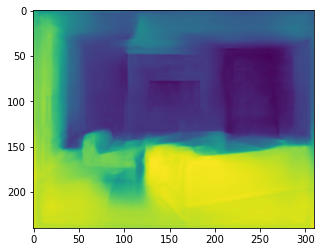

In [7]:
import glob
output_images = []
img_list = glob.glob("./test_images/*")
for i in img_list:
    test_img = cv2.imread(i)
    resized_test_img = cv2.resize(test_img, (620, 480), interpolation=cv2.INTER_AREA)
    resized = torch.from_numpy(np.ascontiguousarray(resized_test_img.transpose((2, 0, 1))))
    resized = resized.float().unsqueeze(dim=0).cuda()
    out = model(resized)
    out = out.cpu().detach().numpy()
    output_images.append(out)
    plt.imshow(out[0,0])

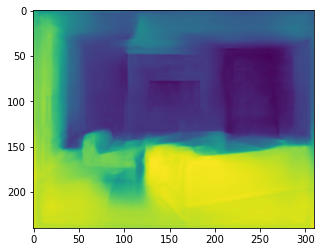

In [8]:
for i in range(len(output_images)):
    plt.imsave(i,output_images[i][0,0])

In [9]:
print(img_list)

['./test_images/3.jpg', './test_images/25.jpg', './test_images/2.jpg', './test_images/4.jpg', './test_images/1.jpg']


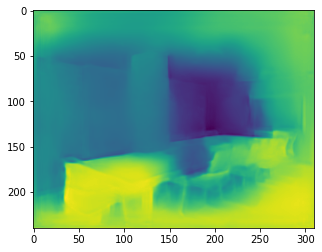

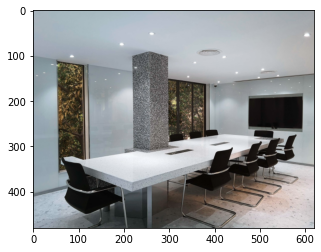

In [10]:
plt.imshow(resized_test_img)

In [ ]:
t